In [1]:
import torch
import torchvision

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, 'util')
import vcpi_util

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Init device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(device)

2.2.1
cpu


### Settings

In [3]:
BATCH_SIZE = 64
EPOCKS = 20
IMG_SIZE = 32
EPOCHS = 1000

PATH_TRAINING_SET = "data/train/Final_Training/Images"
PATH_TEST_SET = "data/test"

### Model Building Aux

In [4]:

def train2(model, train_loader, val_loader, epochs, loss_fn, optimizer,
           scheduler, early_stopper, save_prefix = 'model'):

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        v_correct = 0
        val_loss = 0.0
        with torch.no_grad():
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, t)

                v_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Loss: {val_loss:0.6f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(v_accuracy.cpu().numpy())
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())
 
        ###### Saving ######
        if val_loss < best_val_loss :
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'history': history,
                },
                f'models/{save_prefix}.pt')

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x) # -> (bs, 32, 14, 14)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, num_classes)

        return(x)


class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes)) 

def build_confusion_matrix2(model, dataset, class_names):
    preds = []
    ground_truth = []

    for images, targets in dataset:
        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    num_classes = len(class_names) if class_names else len(set(ground_truth))
    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))




## Model with Transform Set 1
### Data Loading

In [5]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [6]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,transform), batch_size = BATCH_SIZE)

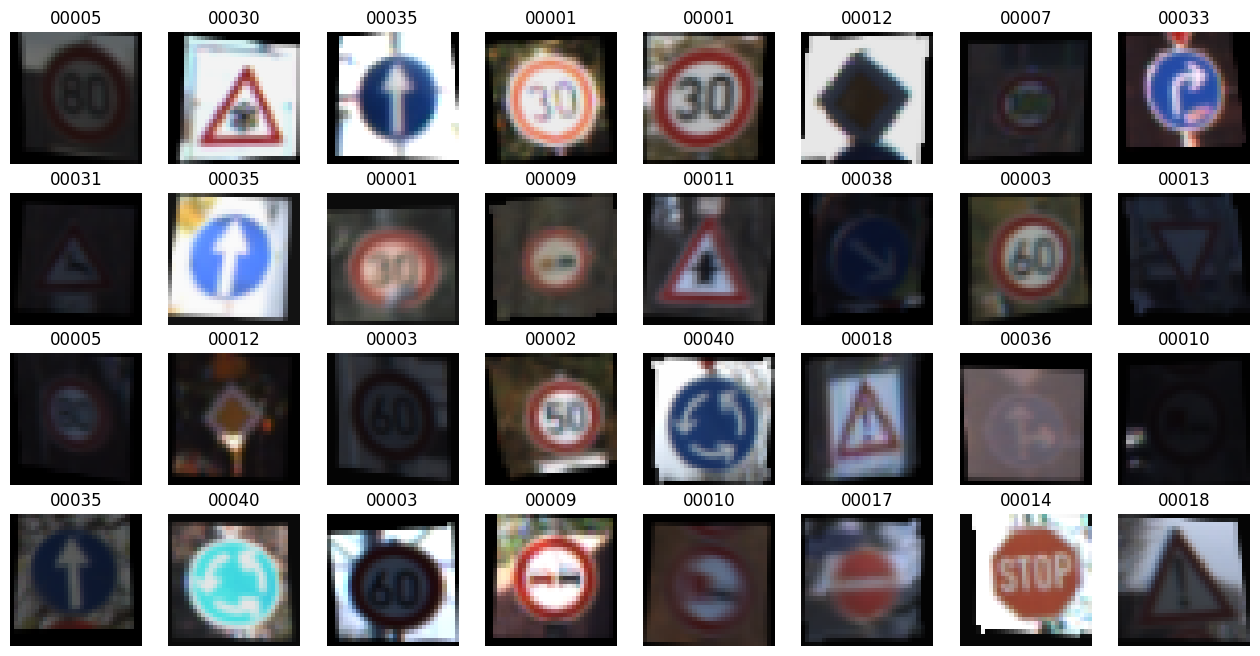

<Figure size 640x480 with 0 Axes>

In [7]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

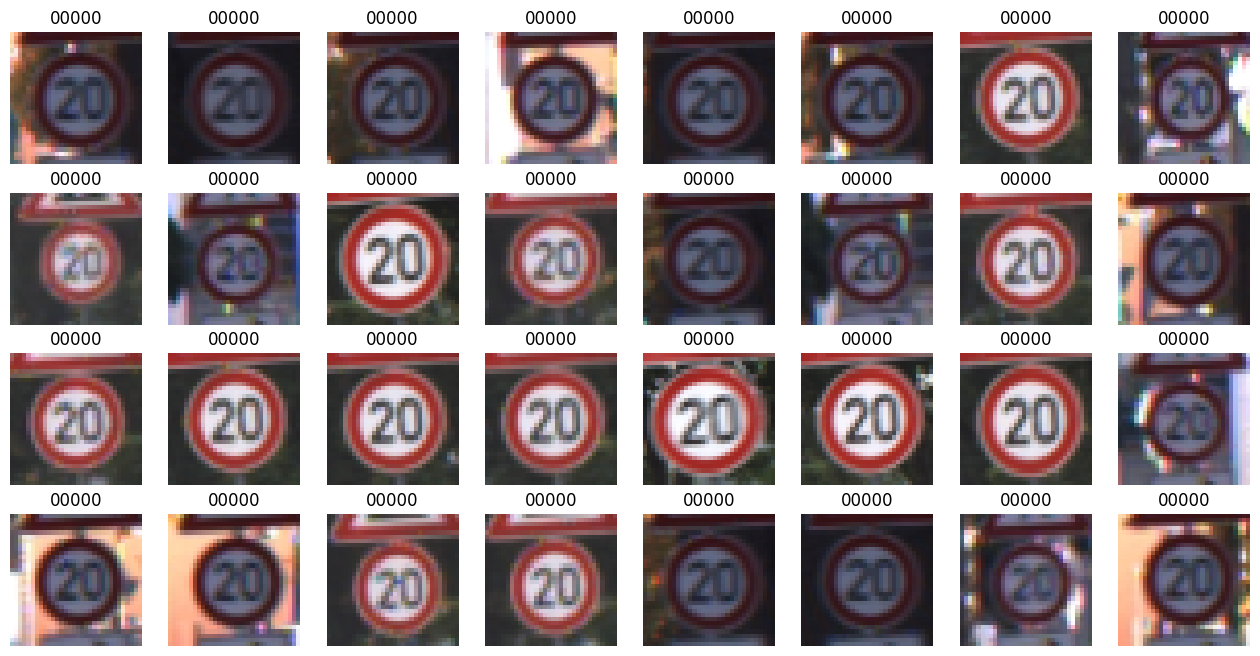

<Figure size 640x480 with 0 Axes>

In [8]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

### Model Training

In [9]:
model = Conv(len(rtrain_set.classes))
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [10]:
history = train2(
    model, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model11')

Epoch: 000; Loss: 0.013167; Accuracy: 77.1523; Val Loss: 0.003096; Val Acc: 94.6183; Elapsed time: 72.0414
Epoch: 001; Loss: 0.001947; Accuracy: 96.8047; Val Loss: 0.001278; Val Acc: 97.9000; Elapsed time: 76.4006
Epoch: 002; Loss: 0.001175; Accuracy: 98.0508; Val Loss: 0.001151; Val Acc: 98.1126; Elapsed time: 75.2019
Epoch: 003; Loss: 0.000900; Accuracy: 98.3823; Val Loss: 0.000744; Val Acc: 98.6142; Elapsed time: 75.9431
Epoch: 004; Loss: 0.000597; Accuracy: 98.9434; Val Loss: 0.000926; Val Acc: 98.3421; Elapsed time: 74.4653
Epoch: 005; Loss: 0.000592; Accuracy: 98.9216; Val Loss: 0.000640; Val Acc: 98.7757; Elapsed time: 74.7352
Epoch: 006; Loss: 0.000462; Accuracy: 99.0892; Val Loss: 0.000583; Val Acc: 98.9458; Elapsed time: 79.3070
Epoch: 007; Loss: 0.000566; Accuracy: 98.8596; Val Loss: 0.000565; Val Acc: 98.8862; Elapsed time: 75.5540
Epoch: 008; Loss: 0.000391; Accuracy: 99.2932; Val Loss: 0.000441; Val Acc: 99.2008; Elapsed time: 77.6594
Epoch: 009; Loss: 0.000335; Accuracy:

### Test Model

In [11]:
evaluate(model, test_loader)

0.9865399599075317

In [ ]:
model_I = Conv(len(rtrain_set.classes)).to(device)
model_I.load_state_dict(torch.load('models/model11.pt')['model'])

---

In [7]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5)
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [8]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,base_transform), batch_size = BATCH_SIZE)

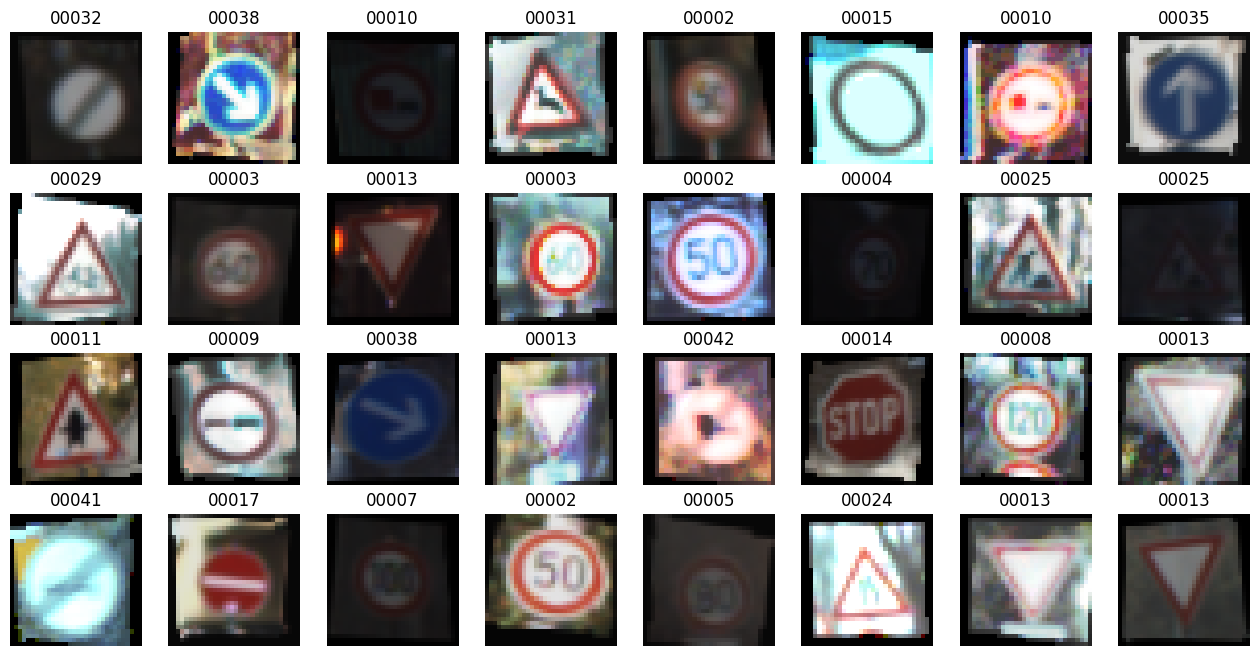

<Figure size 640x480 with 0 Axes>

In [9]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

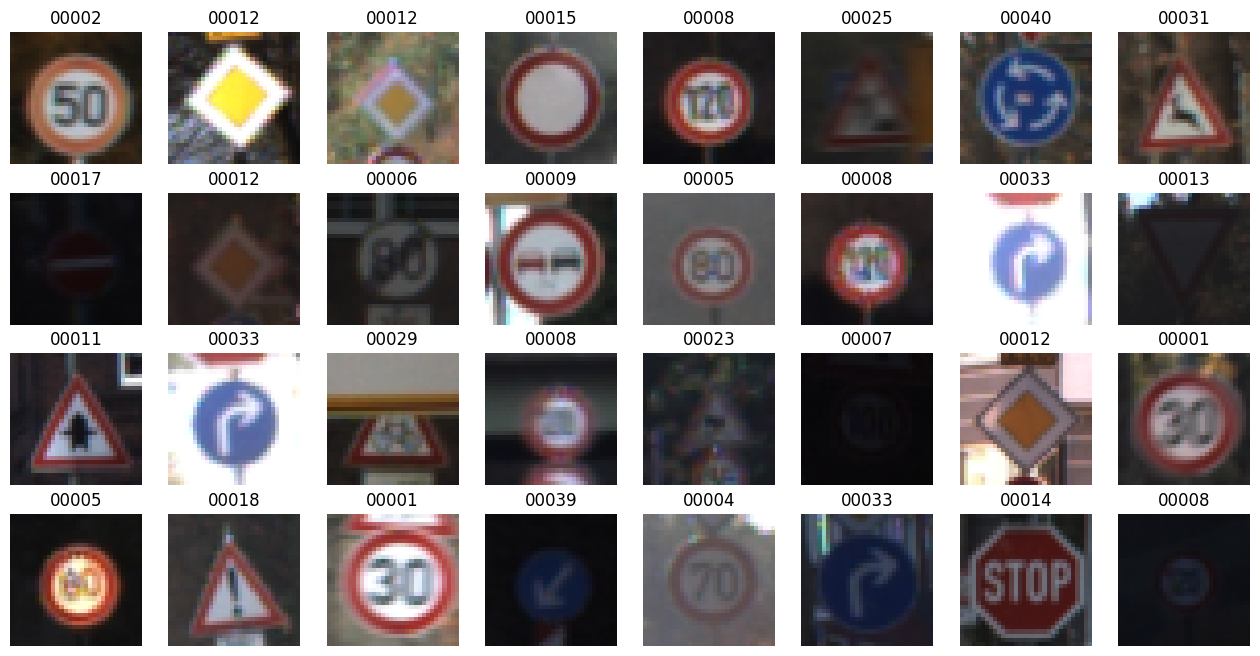

<Figure size 640x480 with 0 Axes>

In [11]:
images, targets = next(iter(val_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

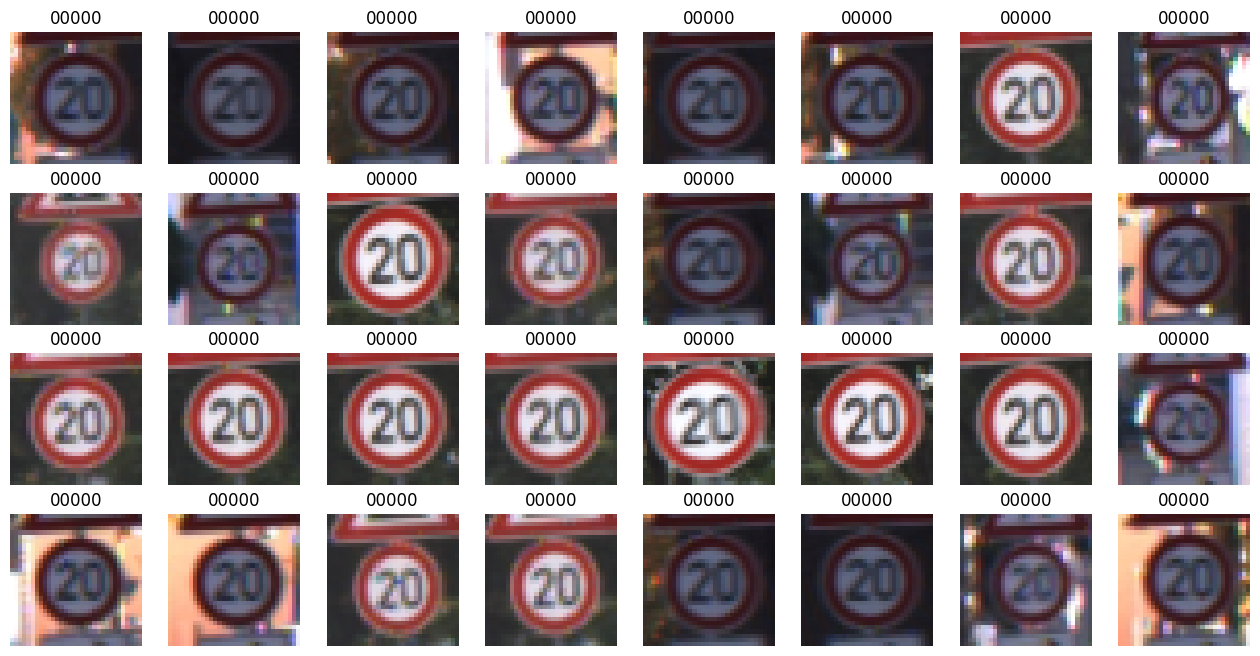

<Figure size 640x480 with 0 Axes>

In [12]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [13]:
model_I = Conv(len(rtrain_set.classes))
model_I.to(device)

optimizer = torch.optim.Adam(model_I.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [14]:
history_I = train2(
    model_I, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model12')

Epoch: 000; Loss: 0.014750; Accuracy: 73.8441; Val Loss: 0.002121; Val Acc: 96.8628; Elapsed time: 57.6487
Epoch: 001; Loss: 0.003226; Accuracy: 94.2762; Val Loss: 0.000854; Val Acc: 98.8947; Elapsed time: 56.1196
Epoch: 002; Loss: 0.002000; Accuracy: 96.2910; Val Loss: 0.000664; Val Acc: 98.8012; Elapsed time: 57.8421
Epoch: 003; Loss: 0.001613; Accuracy: 97.0051; Val Loss: 0.000427; Val Acc: 99.3368; Elapsed time: 58.9514
Epoch: 004; Loss: 0.001309; Accuracy: 97.4059; Val Loss: 0.000531; Val Acc: 99.1243; Elapsed time: 59.4004
Epoch: 005; Loss: 0.001257; Accuracy: 97.4788; Val Loss: 0.000392; Val Acc: 99.3368; Elapsed time: 59.8071
Epoch: 006; Loss: 0.001038; Accuracy: 97.9451; Val Loss: 0.000271; Val Acc: 99.5664; Elapsed time: 60.2020
Epoch: 007; Loss: 0.000834; Accuracy: 98.4078; Val Loss: 0.000646; Val Acc: 98.6567; Elapsed time: 61.2466
Epoch: 008; Loss: 0.000898; Accuracy: 98.3495; Val Loss: 0.000442; Val Acc: 99.1753; Elapsed time: 60.7579
Epoch: 009; Loss: 0.000848; Accuracy:

In [15]:
evaluate(model_I, test_loader)

0.9926365613937378

---

In [19]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [20]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,transform), batch_size = BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

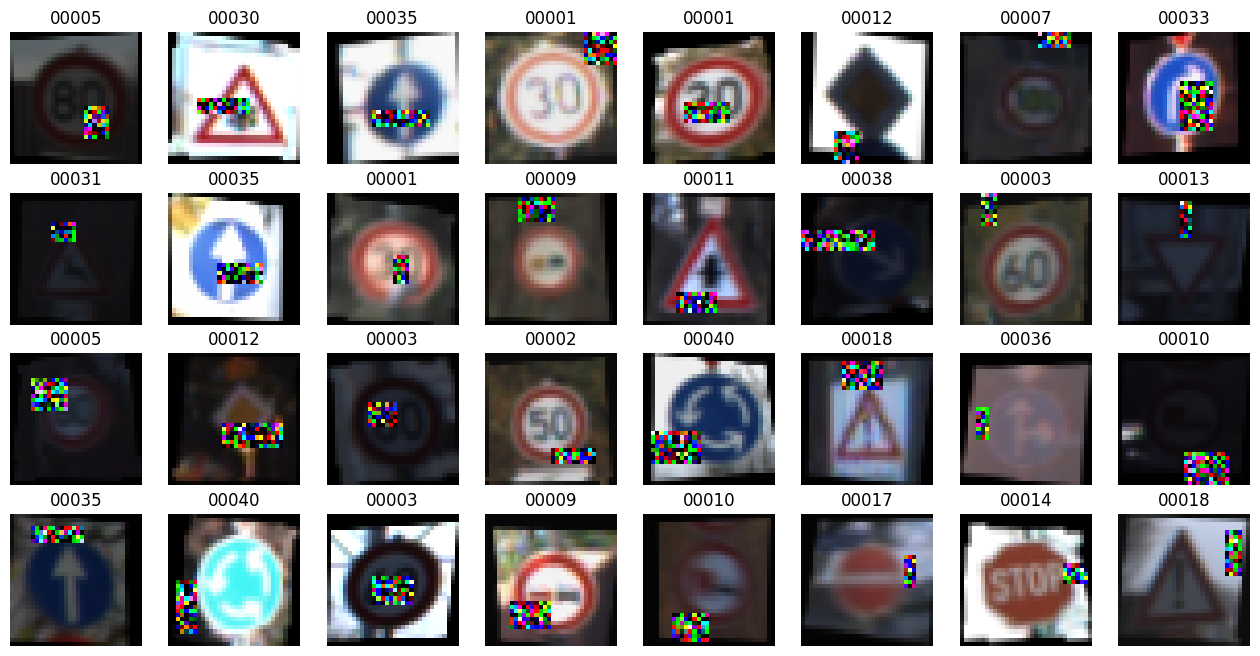

<Figure size 640x480 with 0 Axes>

In [21]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

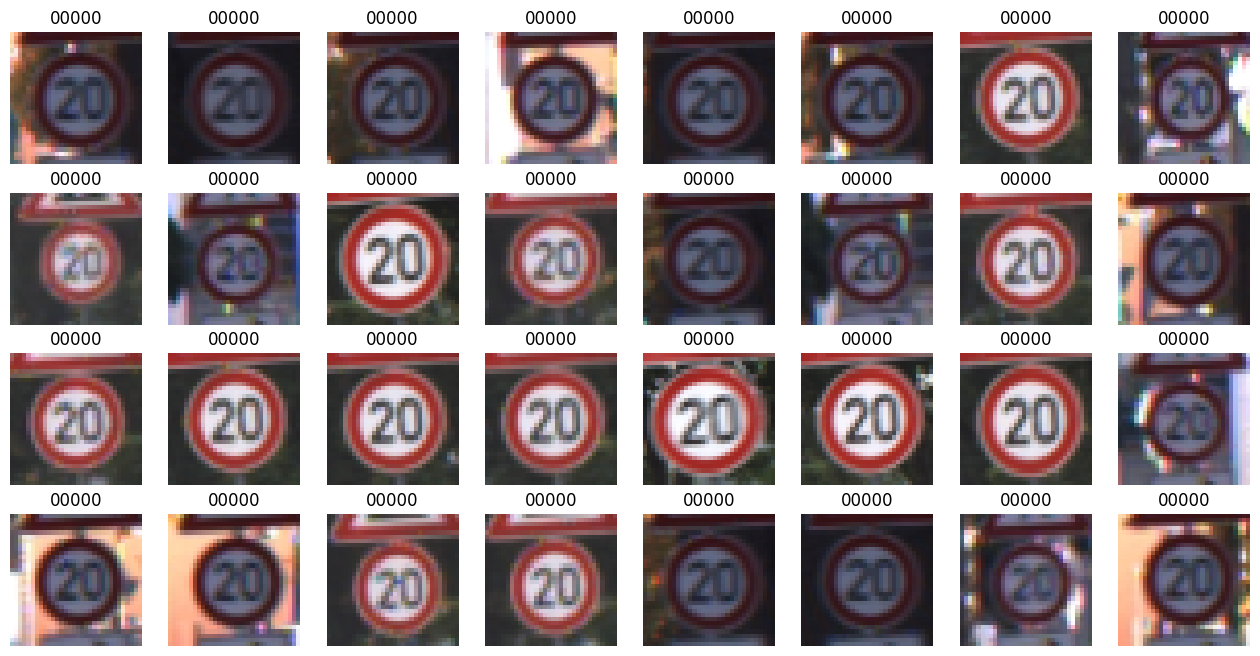

<Figure size 640x480 with 0 Axes>

In [22]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [24]:
model_II = Conv(len(rtrain_set.classes))
model_II.to(device)

optimizer = torch.optim.Adam(model_II.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [26]:
history_II = train2(
    model_II, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model13')

Epoch: 000; Loss: 0.019066; Accuracy: 64.7721; Val Loss: 0.008241; Val Acc: 84.4244; Elapsed time: 70.2496
Epoch: 001; Loss: 0.005971; Accuracy: 88.4468; Val Loss: 0.004999; Val Acc: 89.9677; Elapsed time: 73.1910
Epoch: 002; Loss: 0.004041; Accuracy: 92.0428; Val Loss: 0.004077; Val Acc: 92.1357; Elapsed time: 70.5295
Epoch: 003; Loss: 0.003238; Accuracy: 93.4565; Val Loss: 0.004304; Val Acc: 90.9964; Elapsed time: 70.0553
Epoch: 004; Loss: 0.002917; Accuracy: 94.1341; Val Loss: 0.002663; Val Acc: 94.7883; Elapsed time: 72.0532
Epoch: 005; Loss: 0.002549; Accuracy: 94.8483; Val Loss: 0.002737; Val Acc: 94.0401; Elapsed time: 70.1027
Epoch: 006; Loss: 0.002241; Accuracy: 95.3183; Val Loss: 0.002581; Val Acc: 94.6948; Elapsed time: 70.3691
Epoch: 007; Loss: 0.002227; Accuracy: 95.3510; Val Loss: 0.002115; Val Acc: 95.6555; Elapsed time: 79.6001
Epoch: 008; Loss: 0.001925; Accuracy: 96.0105; Val Loss: 0.002040; Val Acc: 95.8765; Elapsed time: 116.1466
Epoch: 009; Loss: 0.001833; Accuracy

In [1]:
evaluate(model_II, test_loader)

NameError: name 'evaluate' is not defined

---

In [35]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [36]:
PATH_TRAINING_ENHANCED = "data/train_enhanced"
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,transform), batch_size = BATCH_SIZE)

train_enhanced = torchvision.datasets.ImageFolder(root=PATH_TRAINING_ENHANCED, transform = base_transform)
train_enhanced_loader = torch.utils.data.DataLoader(train_enhanced, batch_size = BATCH_SIZE)

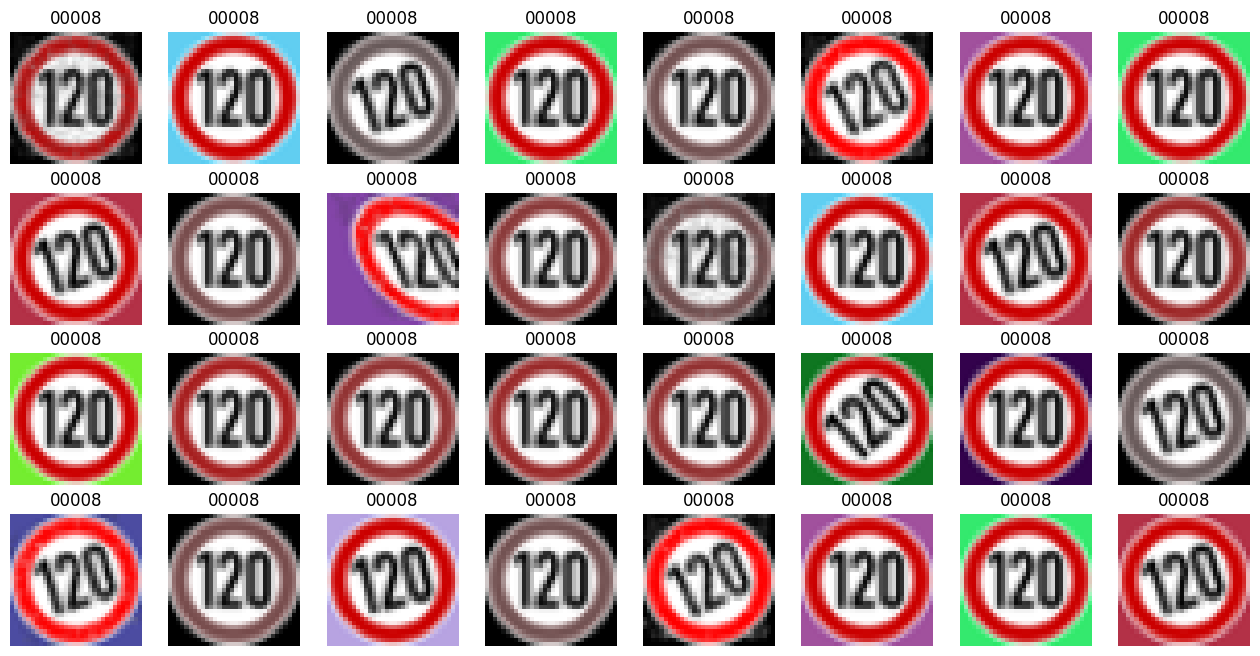

<Figure size 640x480 with 0 Axes>

In [37]:
images, targets = next(iter(train_enhanced_loader))
vcpi_util.show_images(4,8,images,targets,train_enhanced.classes)

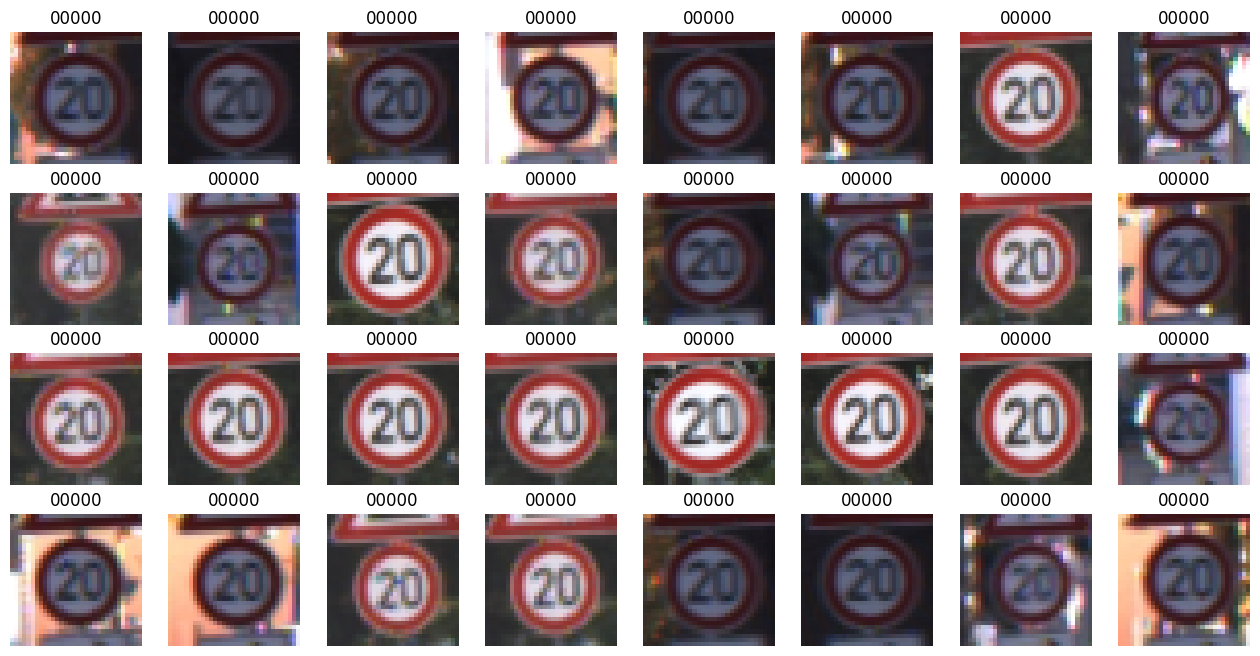

<Figure size 640x480 with 0 Axes>

In [39]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [ ]:
model_III = Conv(len(rtrain_set.classes))
model_III.to(device)

optimizer = torch.optim.Adam(model_III.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(5)

In [ ]:
history_III = train2(
    model_III, train_enhanced_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model14')

In [ ]:
evaluate(model_III, test_loader)

---

In [2]:
from PIL import Image, ImageEnhance
import random
import os

In [3]:
IMAGES_PER_CLASS = 2000

PATH_TRAINING_BALANCED = f"data/train_balanced_{IMAGES_PER_CLASS}"

In [ ]:
classes = os.listdir(f'data/train_balanced_{IMAGES_PER_CLASS}/Images')

list_img = []
for cla in classes:
    list_img = os.listdir(f'data/train_balanced_{IMAGES_PER_CLASS}/Images/{cla}')
    random.shuffle(list_img)
    for k in range(len(list_img), IMAGES_PER_CLASS):

        filename = f'data/train_balanced_{IMAGES_PER_CLASS}/Images/{cla}/{list_img[(k - len(list_img)) % len(list_img)]}'
        im = Image.open(filename)

        r = random.uniform(-10.0,10.0)
        im = im.rotate(r)
        r1 = random.uniform(-3.0,3.0)
        r2 = random.uniform(-3.0,3.0)

        im = im.transform(im.size, Image.Transform.AFFINE, (1, 0, r1, 0, 1, r2))

        r = random.uniform(1.0, 1.3)
        im = ImageEnhance.Sharpness(im)
        im = im.enhance(r)

        r = random.uniform(1.0, 1.3)
        im = ImageEnhance.Contrast(im)
        im = im.enhance(r)
        
        im = im.resize((32,32))

        im.save(f'data/train_balanced_{IMAGES_PER_CLASS}/Images/{cla}/_{k}.png')

In [ ]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.RandomPhotometricDistort()
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [ ]:
PATH_TRAINING_BALANCED = f"data/train_balanced_{IMAGES_PER_CLASS}/Images/"
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,transform), batch_size = BATCH_SIZE)

train_balanced = torchvision.datasets.ImageFolder(root=PATH_TRAINING_BALANCED, transform = base_transform)
train_balanced_loader = torch.utils.data.DataLoader(train_balanced, batch_size = BATCH_SIZE)

In [ ]:
images, targets = next(iter(train_balanced_loader))
vcpi_util.show_images(4,8,images,targets,train_balanced.classes)

In [ ]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [ ]:
model_IV = Conv(len(rtrain_set.classes))
model_IV.to(device)

optimizer = torch.optim.Adam(model_III.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(5)

In [ ]:
history_IV = train2(
    model_IV, train_balanced_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model15')

In [ ]:
evaluate(model_IV, test_loader)

---

# SGD

---

In [30]:
BATCH_SIZE = 64
EPOCKS = 20
IMG_SIZE = 32
EPOCHS = 1000

PATH_TRAINING_SET = "data/train/Final_Training/Images"
PATH_TEST_SET = "data/test"

In [31]:
def train(model, train_loader, test_loader, epochs, loss_fn, optimizer):

    history = {}
    history['accuracy'] = []
    history['test_acc'] = []
    history['loss'] = []
    best_t_accuracy = -np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)
            
            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss.detach()
            correct += (predicted == targets).sum()

        model.eval()
        t_correct = 0
        with torch.no_grad():
            for i,t in test_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)

                t_correct += (p == t).sum()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(test_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.4f}; Accuracy: {accuracy:0.4f}; Test_Acc: {t_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['test_acc'].append(t_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')
           
    return(history)

def train2(model, train_loader, val_loader, epochs, loss_fn, optimizer,
           scheduler, early_stopper, save_prefix = 'model'):

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        v_correct = 0
        val_loss = 0.0
        with torch.no_grad():
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, t)

                v_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Loss: {val_loss:0.6f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(v_accuracy.cpu().numpy())
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())
 
        ###### Saving ######
        if val_loss < best_val_loss :
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'history': history,
                'val_acc': v_accuracy
                },
                f'models/{save_prefix}.pt')

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x) # -> (bs, 32, 14, 14)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, num_classes)

        return(x)


class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes)) 

def build_confusion_matrix2(model, dataset, class_names):
    preds = []
    ground_truth = []

    for images, targets in dataset:
        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    num_classes = len(class_names) if class_names else len(set(ground_truth))
    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))




## Model with Transform Set 1
### Data Loading

In [32]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [33]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,transform), batch_size = BATCH_SIZE)

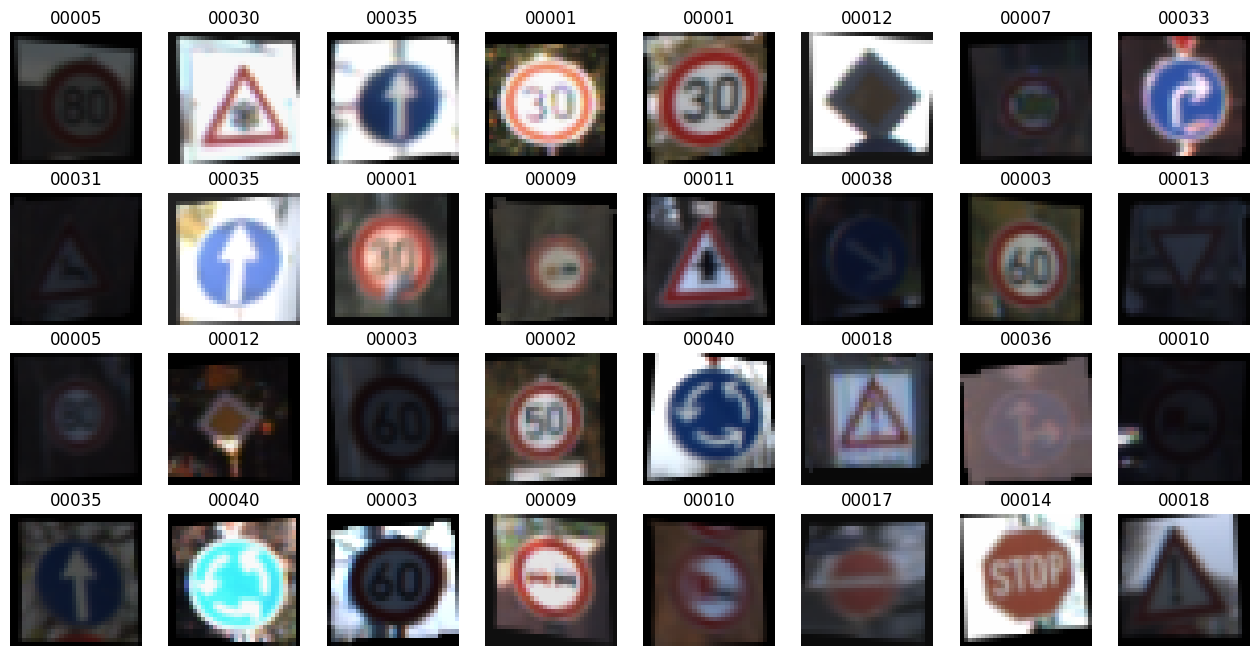

<Figure size 640x480 with 0 Axes>

In [34]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

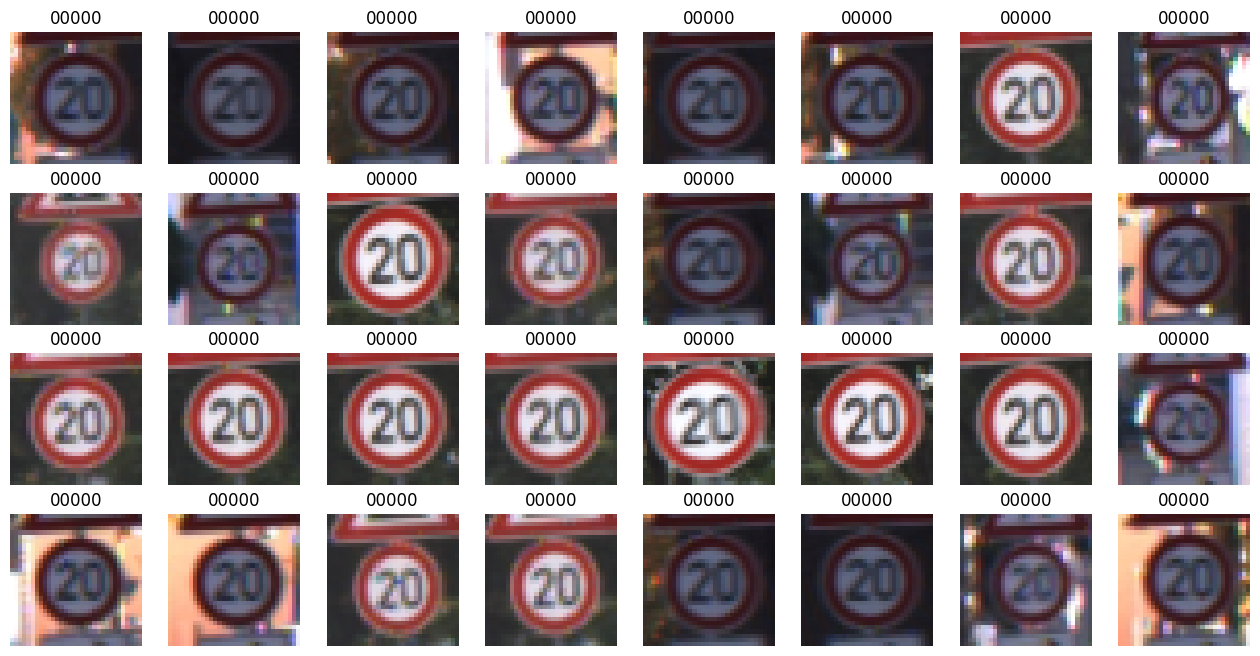

<Figure size 640x480 with 0 Axes>

In [35]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [36]:
model = Conv(len(rtrain_set.classes))
model.to(device)

optimizer = torch.optim.SGD(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [37]:
history = train2(
    model, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model11')

Epoch: 000; Loss: 0.049149; Accuracy: 20.2609; Val Loss: 0.043079; Val Acc: 31.1682; Elapsed time: 80.2707
Epoch: 001; Loss: 0.038637; Accuracy: 37.3083; Val Loss: 0.035021; Val Acc: 41.6426; Elapsed time: 75.0590
Epoch: 002; Loss: 0.032275; Accuracy: 45.6553; Val Loss: 0.029875; Val Acc: 49.0393; Elapsed time: 73.9604
Epoch: 003; Loss: 0.027795; Accuracy: 52.5085; Val Loss: 0.026074; Val Acc: 55.7983; Elapsed time: 75.3659
Epoch: 004; Loss: 0.024311; Accuracy: 59.4564; Val Loss: 0.023041; Val Acc: 62.0813; Elapsed time: 78.2887
Epoch: 005; Loss: 0.021474; Accuracy: 65.2385; Val Loss: 0.020220; Val Acc: 67.8201; Elapsed time: 79.0617
Epoch: 006; Loss: 0.019085; Accuracy: 70.1461; Val Loss: 0.018171; Val Acc: 71.2294; Elapsed time: 80.2275
Epoch: 007; Loss: 0.016972; Accuracy: 73.7640; Val Loss: 0.016277; Val Acc: 74.8002; Elapsed time: 78.6769
Epoch: 008; Loss: 0.015258; Accuracy: 77.2179; Val Loss: 0.014586; Val Acc: 77.6484; Elapsed time: 77.8323
Epoch: 009; Loss: 0.013773; Accuracy:

In [38]:
evaluate(model, test_loader)

0.9652414917945862

In [ ]:
model_I = Conv(len(rtrain_set.classes)).to(device)
model_I.load_state_dict(torch.load('models/model11.pt')['model'])

In [ ]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.RandomPhotometricDistort(p=0.3),
        v2.RandomGrayscale(p=0.2),
        v2.RandomEqualize(p=0.5),
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [ ]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,transform), batch_size = BATCH_SIZE)

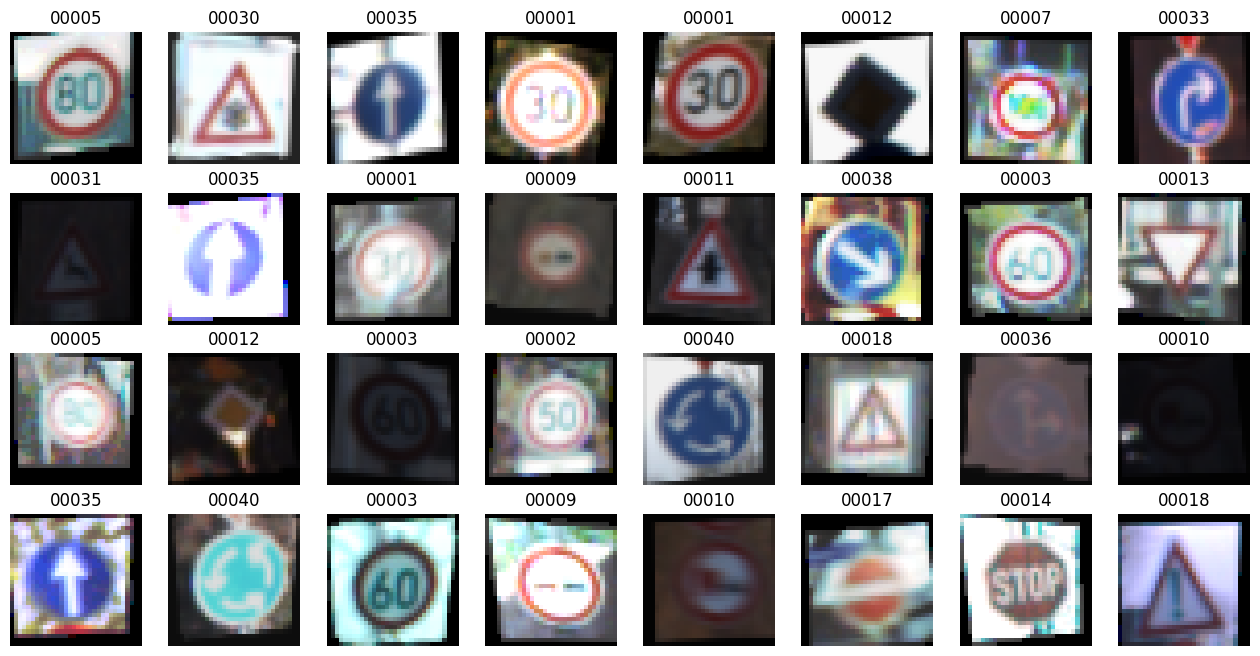

<Figure size 640x480 with 0 Axes>

In [ ]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

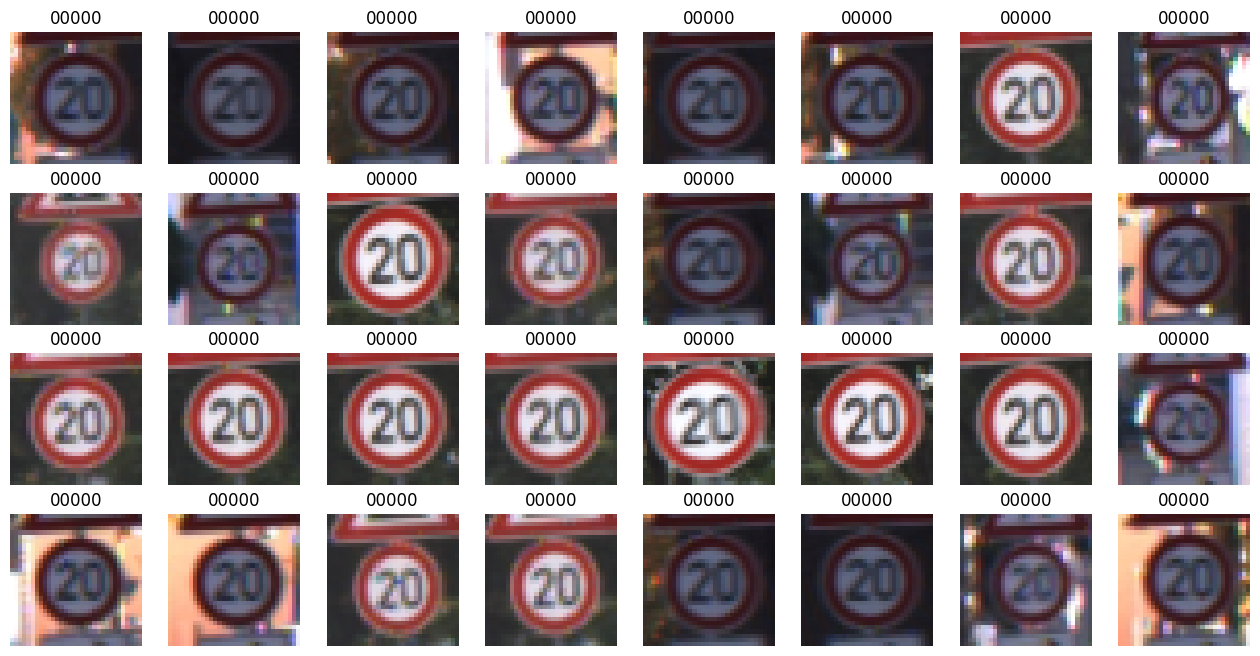

<Figure size 640x480 with 0 Axes>

In [ ]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [ ]:
model_I = Conv(len(rtrain_set.classes))
model_I.to(device)

optimizer = torch.optim.SGD(model_I.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(5)

In [ ]:
history_I = train2(
    model_I, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model12_SGD')

Epoch: 000; Loss: 0.015668; Accuracy: 72.3394; Val Loss: 0.005119; Val Acc: 90.5628; Elapsed time: 64.3197
Epoch: 001; Loss: 0.003577; Accuracy: 93.4273; Val Loss: 0.003197; Val Acc: 94.3802; Elapsed time: 63.8111
Epoch: 002; Loss: 0.002161; Accuracy: 96.0506; Val Loss: 0.002368; Val Acc: 95.6640; Elapsed time: 65.3229
Epoch: 003; Loss: 0.001742; Accuracy: 96.7319; Val Loss: 0.002006; Val Acc: 96.1401; Elapsed time: 66.4301
Epoch: 004; Loss: 0.001272; Accuracy: 97.6245; Val Loss: 0.001425; Val Acc: 97.2964; Elapsed time: 67.1761
Epoch: 005; Loss: 0.001219; Accuracy: 97.5954; Val Loss: 0.001099; Val Acc: 97.9000; Elapsed time: 68.5985
Epoch: 006; Loss: 0.001057; Accuracy: 97.9524; Val Loss: 0.001229; Val Acc: 97.5854; Elapsed time: 68.3134
Epoch: 007; Loss: 0.000919; Accuracy: 98.2621; Val Loss: 0.000858; Val Acc: 98.2571; Elapsed time: 68.6942
Epoch: 008; Loss: 0.000897; Accuracy: 98.1601; Val Loss: 0.001299; Val Acc: 97.4154; Elapsed time: 68.7587
Epoch: 009; Loss: 0.000806; Accuracy:

In [ ]:
evaluate(model_I, test_loader)

0.9900237321853638

In [ ]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [ ]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,transform), batch_size = BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

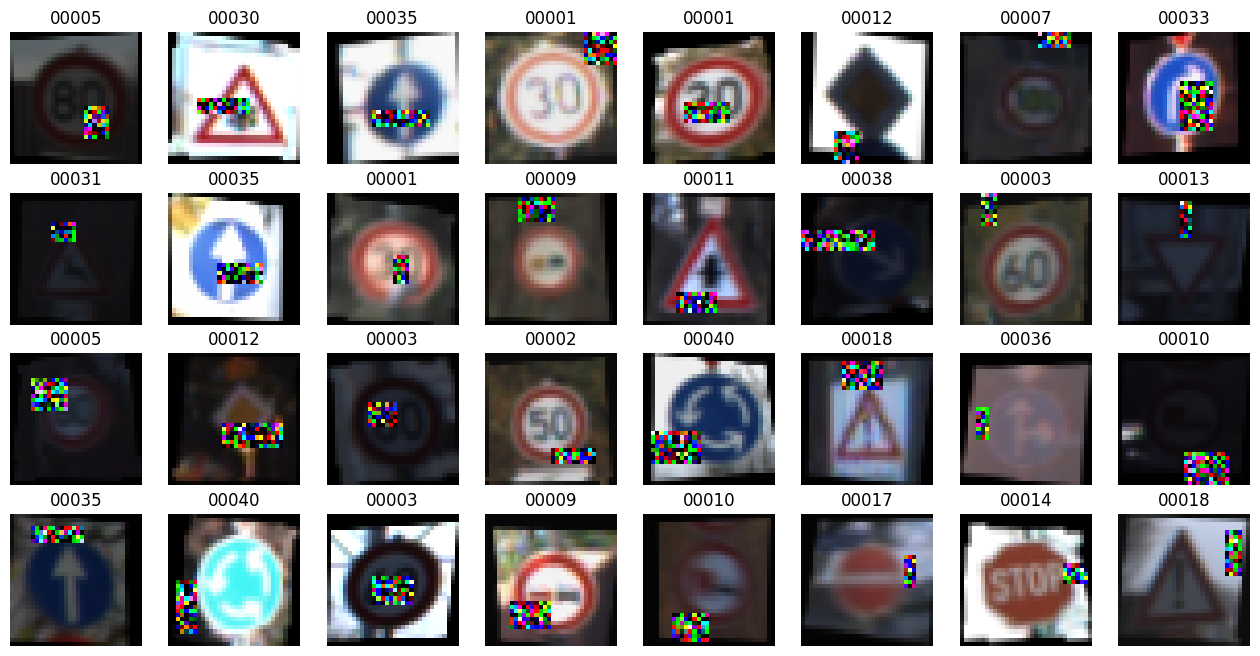

<Figure size 640x480 with 0 Axes>

In [ ]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

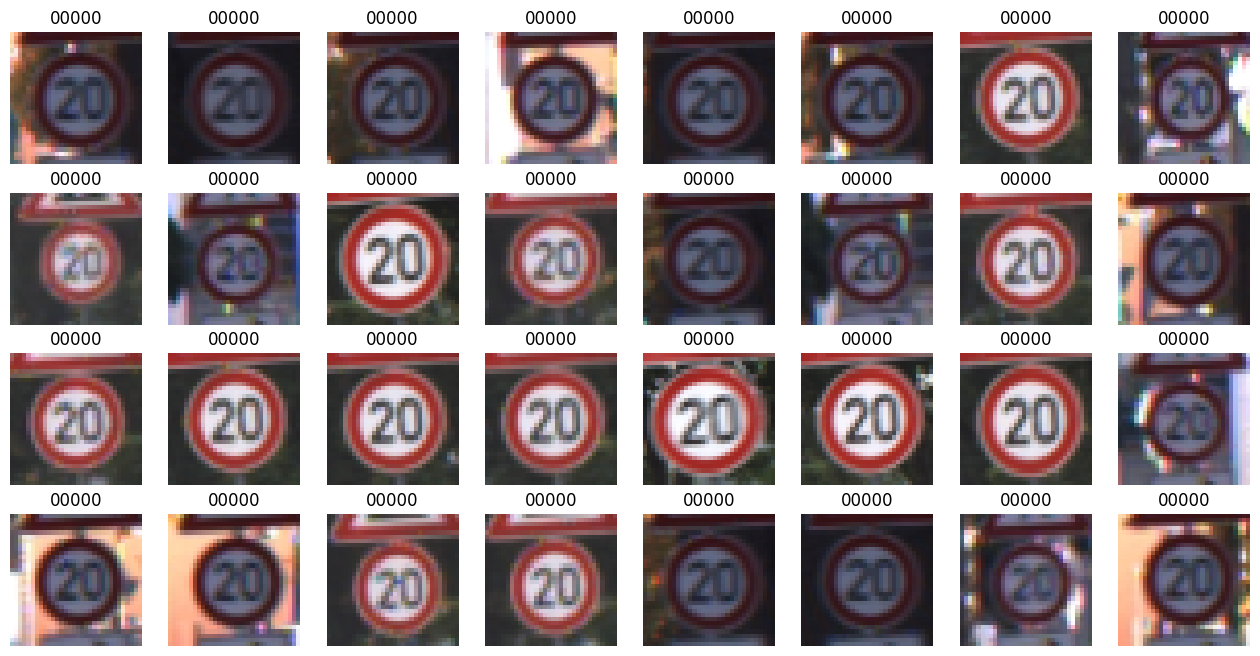

<Figure size 640x480 with 0 Axes>

In [ ]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [ ]:
model_II = Conv(len(rtrain_set.classes))
model_II.to(device)

optimizer = torch.optim.SGD(model_II.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [ ]:
history_II = train2(
    model_II, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model13_SGD')

Epoch: 000; Loss: 0.019066; Accuracy: 64.7721; Val Loss: 0.008241; Val Acc: 84.4244; Elapsed time: 70.2496
Epoch: 001; Loss: 0.005971; Accuracy: 88.4468; Val Loss: 0.004999; Val Acc: 89.9677; Elapsed time: 73.1910
Epoch: 002; Loss: 0.004041; Accuracy: 92.0428; Val Loss: 0.004077; Val Acc: 92.1357; Elapsed time: 70.5295
Epoch: 003; Loss: 0.003238; Accuracy: 93.4565; Val Loss: 0.004304; Val Acc: 90.9964; Elapsed time: 70.0553
Epoch: 004; Loss: 0.002917; Accuracy: 94.1341; Val Loss: 0.002663; Val Acc: 94.7883; Elapsed time: 72.0532
Epoch: 005; Loss: 0.002549; Accuracy: 94.8483; Val Loss: 0.002737; Val Acc: 94.0401; Elapsed time: 70.1027
Epoch: 006; Loss: 0.002241; Accuracy: 95.3183; Val Loss: 0.002581; Val Acc: 94.6948; Elapsed time: 70.3691
Epoch: 007; Loss: 0.002227; Accuracy: 95.3510; Val Loss: 0.002115; Val Acc: 95.6555; Elapsed time: 79.6001
Epoch: 008; Loss: 0.001925; Accuracy: 96.0105; Val Loss: 0.002040; Val Acc: 95.8765; Elapsed time: 116.1466
Epoch: 009; Loss: 0.001833; Accuracy

In [ ]:
evaluate(model_II, test_loader)

0.9879651665687561

---

In [ ]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5)
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [ ]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,transform), batch_size = BATCH_SIZE)

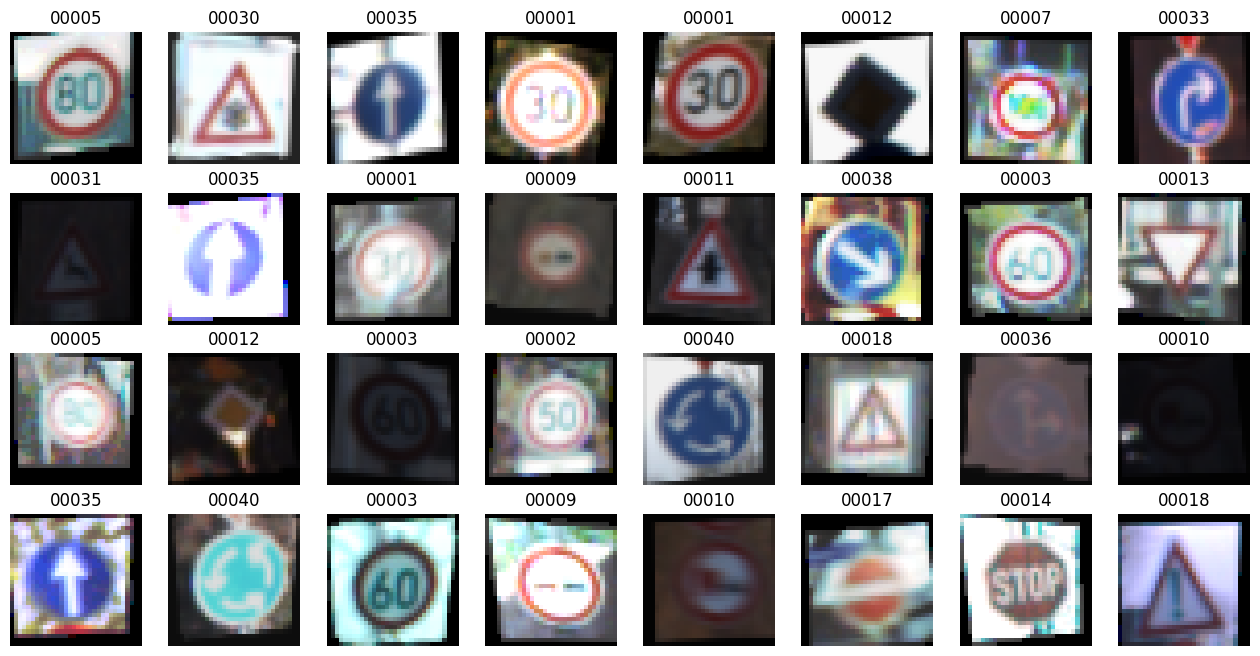

<Figure size 640x480 with 0 Axes>

In [ ]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

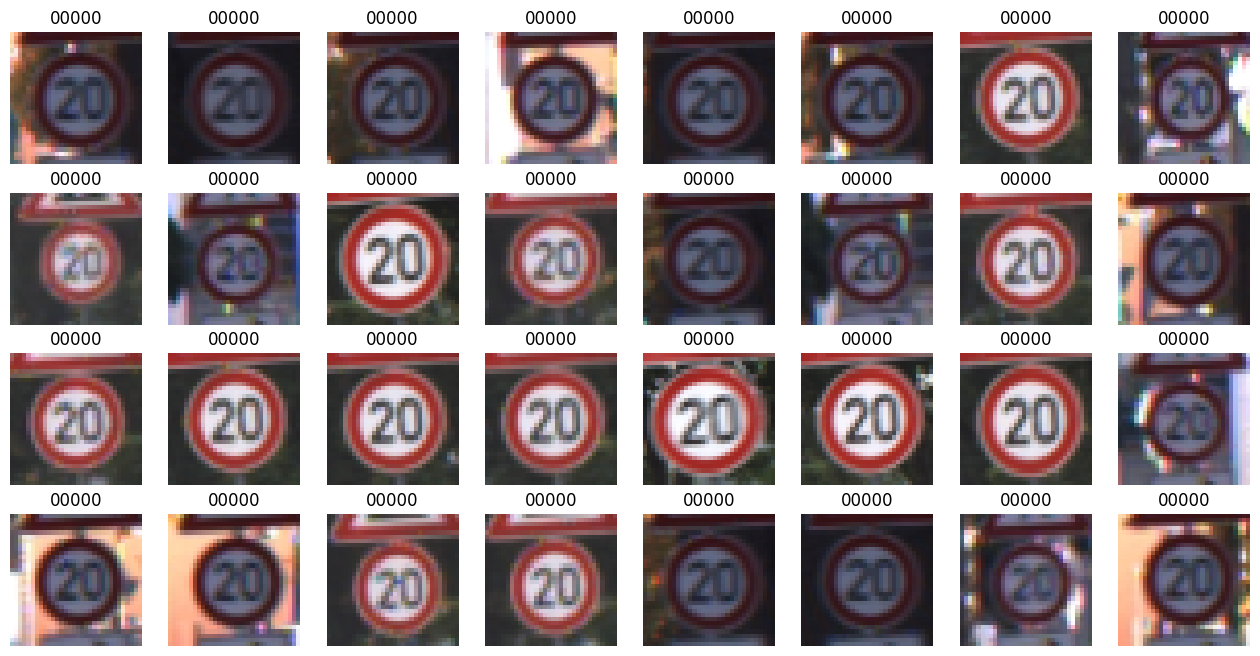

<Figure size 640x480 with 0 Axes>

In [ ]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [ ]:
model_I = Conv(len(rtrain_set.classes))
model_I.to(device)

optimizer = torch.optim.Adam(model_I.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(5)

In [ ]:
history_I = train2(
    model_I, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model14')

Epoch: 000; Loss: 0.015668; Accuracy: 72.3394; Val Loss: 0.005119; Val Acc: 90.5628; Elapsed time: 64.3197
Epoch: 001; Loss: 0.003577; Accuracy: 93.4273; Val Loss: 0.003197; Val Acc: 94.3802; Elapsed time: 63.8111
Epoch: 002; Loss: 0.002161; Accuracy: 96.0506; Val Loss: 0.002368; Val Acc: 95.6640; Elapsed time: 65.3229
Epoch: 003; Loss: 0.001742; Accuracy: 96.7319; Val Loss: 0.002006; Val Acc: 96.1401; Elapsed time: 66.4301
Epoch: 004; Loss: 0.001272; Accuracy: 97.6245; Val Loss: 0.001425; Val Acc: 97.2964; Elapsed time: 67.1761
Epoch: 005; Loss: 0.001219; Accuracy: 97.5954; Val Loss: 0.001099; Val Acc: 97.9000; Elapsed time: 68.5985
Epoch: 006; Loss: 0.001057; Accuracy: 97.9524; Val Loss: 0.001229; Val Acc: 97.5854; Elapsed time: 68.3134
Epoch: 007; Loss: 0.000919; Accuracy: 98.2621; Val Loss: 0.000858; Val Acc: 98.2571; Elapsed time: 68.6942
Epoch: 008; Loss: 0.000897; Accuracy: 98.1601; Val Loss: 0.001299; Val Acc: 97.4154; Elapsed time: 68.7587
Epoch: 009; Loss: 0.000806; Accuracy:

In [ ]:
evaluate(model_I, test_loader)

0.9900237321853638

---

# New CNN

---

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedConv(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedConv, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (bs, 32, 16, 16)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (bs, 64, 8, 8)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> (bs, 128, 4, 4)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # -> (bs, 256, 2, 2)
        
        x = torch.flatten(x, 1)  # -> (bs, 256 * 2 * 2)
        
        x = F.relu(self.fc1(x))  # -> (bs, 512)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # -> (bs, 256)
        x = self.dropout(x)
        x = self.fc3(x)          # -> (bs, num_classes)
        
        return x

In [61]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5)
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [62]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,transform), batch_size = BATCH_SIZE)

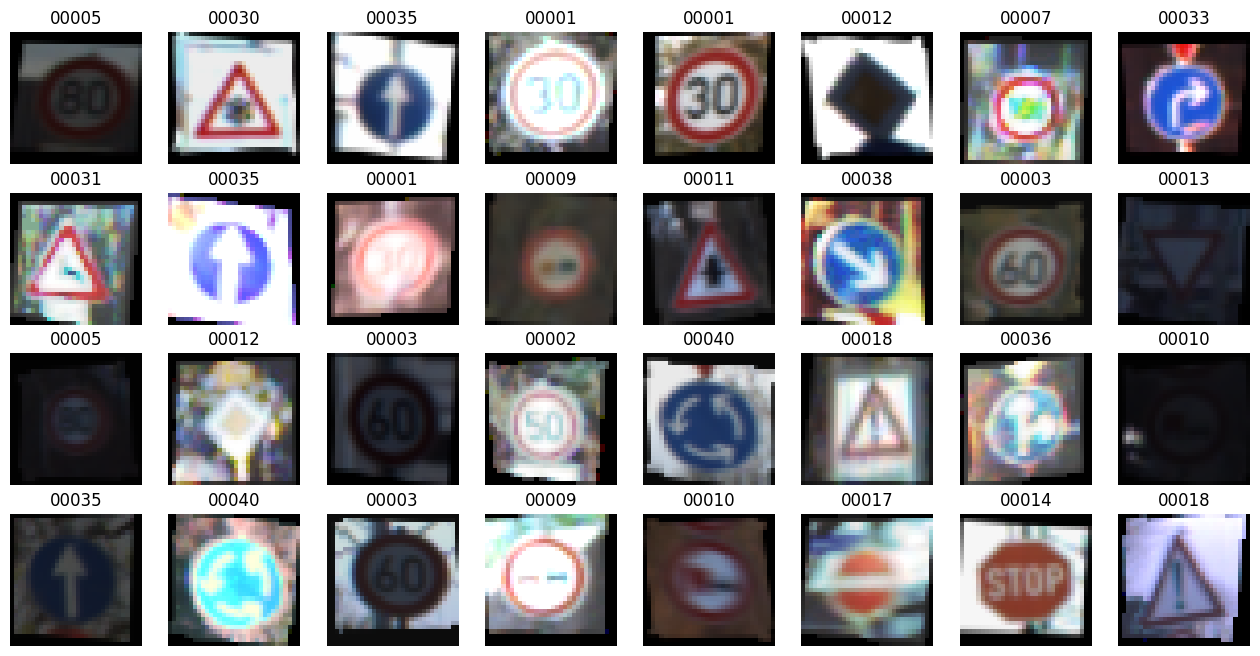

<Figure size 640x480 with 0 Axes>

In [63]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

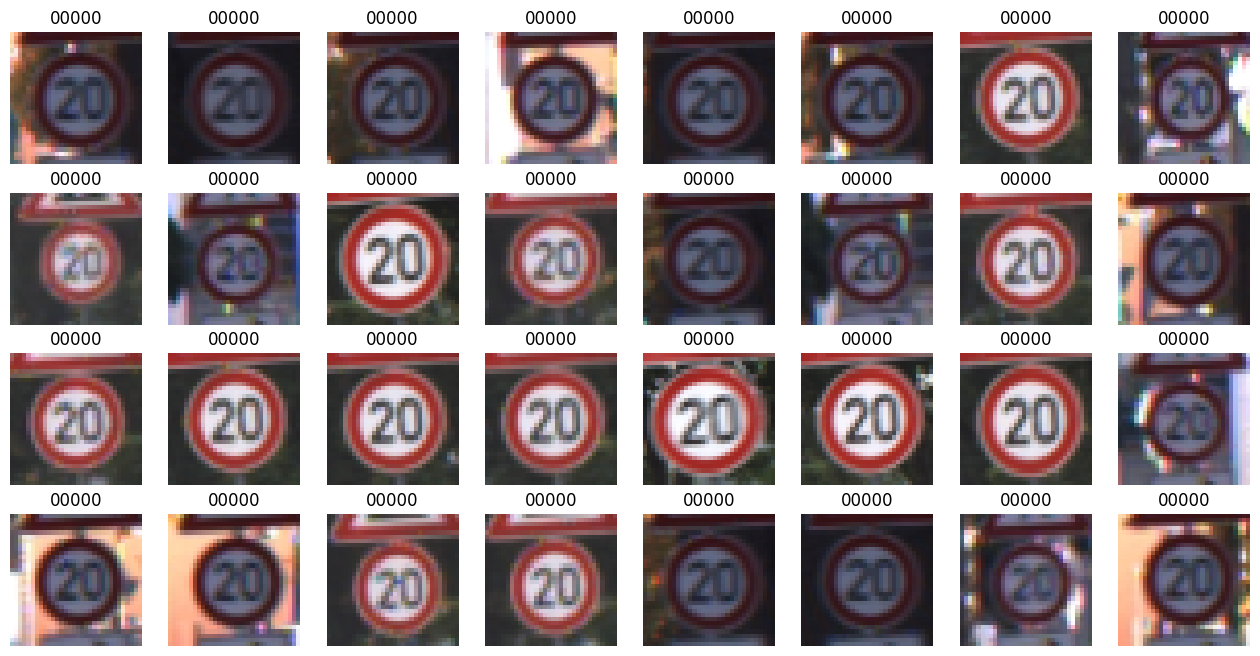

<Figure size 640x480 with 0 Axes>

In [64]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [65]:
model_I_II = EnhancedConv(len(rtrain_set.classes))
model_I_II.to(device)

optimizer = torch.optim.Adam(model_I_II.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [66]:
history_I = train2(
    model_I_II, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model12_CON2')

Epoch: 000; Loss: 0.037777; Accuracy: 28.0176; Val Loss: 0.022672; Val Acc: 49.5749; Elapsed time: 81.2610
Epoch: 001; Loss: 0.019481; Accuracy: 57.0518; Val Loss: 0.010789; Val Acc: 75.8970; Elapsed time: 84.2094
Epoch: 002; Loss: 0.012637; Accuracy: 72.5799; Val Loss: 0.007600; Val Acc: 84.1949; Elapsed time: 77.0544
Epoch: 003; Loss: 0.009241; Accuracy: 80.3111; Val Loss: 0.005685; Val Acc: 88.2758; Elapsed time: 75.1420
Epoch: 004; Loss: 0.007657; Accuracy: 83.8962; Val Loss: 0.005032; Val Acc: 89.6021; Elapsed time: 76.9569
Epoch: 005; Loss: 0.006342; Accuracy: 86.9749; Val Loss: 0.004414; Val Acc: 90.6563; Elapsed time: 76.3413
Epoch: 006; Loss: 0.005303; Accuracy: 89.1719; Val Loss: 0.004326; Val Acc: 91.0984; Elapsed time: 77.7624
Epoch: 007; Loss: 0.004868; Accuracy: 90.2467; Val Loss: 0.002803; Val Acc: 94.4652; Elapsed time: 76.7678
Epoch: 008; Loss: 0.004286; Accuracy: 91.4854; Val Loss: 0.002266; Val Acc: 95.2729; Elapsed time: 77.7575
Epoch: 009; Loss: 0.004066; Accuracy:

In [67]:
evaluate(model_I_II, test_loader)

0.9749802350997925